In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

import skimage
import skimage.data, skimage.util

np.random.seed(42)
ROOT_PATH = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
ROOT_PATH

'/home/franchetto4/github/StatMatMethodsAI'

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv("/content/drive/MyDrive/data.csv")
except:
    data = pd.read_csv(os.path.join(ROOT_PATH, "data", "data.csv"))
# Load the data

print("Shape of data {}".format(data.shape))

Shape of data (42000, 785)


In [3]:
print(data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

We can see that the data is composed by 785 columns, of which the first one is the label of the sample, and the other 784 are the actual pixel values

In [4]:
# Convert into array
data = np.array(data)

# Split into samples and labels (X and Y)
X = data[:, 1:]
X = X.T

Y = data[:, 0]

print(X.shape, Y.shape)

d, N = X.shape

(784, 42000) (42000,)


In [5]:
def get_data_from_index(X, Y, indexes):
    
    # start from empty lists for both samples and labels
    final_X = []
    final_Y = []

    # for each chosen label
    for k in indexes:
        # find which samples have label=k
        idxs_k = (Y == k)
        # slice the samples and append them to a list
        final_X.append( X[:, idxs_k] )
        # same thing to the labels
        final_Y.append( Y[idxs_k] )

    # concatenate together all the previous iterations
    X = np.concatenate(final_X, axis=1)
    Y = np.concatenate(final_Y)

    # return the new dataset and labels
    return X, Y

In [6]:
indeces = [0, 6, 9]
X, Y = get_data_from_index(X, Y, indeces)
print("X shape: {}, Y shape: {}".format(
    X.shape,
    Y.shape
))

print("Kept samples choosing indeces {}: {:.2f}%".format(
    indeces,
    X.shape[1]/N*100
))

X shape: (784, 12457), Y shape: (12457,)
Kept samples choosing indeces [0, 6, 9]: 29.66%


In [7]:
# 80% to train, the rest to test
train_split = 0.8
N_train = round(X.shape[1]*train_split)

In [8]:
def data_splits(X, Y, N_train):
    N = X.shape[1]

    # getting an array with indeces from 0 to N-1
    indeces = np.arange(N)
    # shuffling randomly
    np.random.shuffle(indeces)

    # get the first N_train for the train split (but now they are random)
    train_idx = indeces[:N_train]
    # the rest are for test split
    test_idx = indeces[N_train:]

    # slice the original datasets with an index array
    X_train = X[:, train_idx]  
    Y_train = Y[train_idx]
    
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    # put in tuples the two splits
    return (X_train, Y_train), (X_test, Y_test)

In [9]:
# get the train and test splits both for samples and for lables
(X_train, Y_train), (X_test, Y_test) = data_splits(X, Y, N_train)

print("X_train shape: {}, Y_train shape: {}".format(
    X_train.shape,
    Y_train.shape
))

X_train shape: (784, 9966), Y_train shape: (9966,)


In [10]:
# set the dimensionality of the reduction
k = 2

In [11]:
def PCA(X, k):

    # Find the centroid of the dataset
    centroid = np.mean(X, axis=1)

    # Translate the whole dataset so that its center is in 0
    X_c = X - centroid.reshape((d, 1))

    # Compute SVD on the shifted dataset matrix
    U, S, VT = np.linalg.svd(X_c, full_matrices=False)

    # Take only the first k columns on the U matrix: this is now the projection matrix for the PCA
    U_k = U[:, :k]

    # print("Projection matrix shape: {}".format(U_k.shape))

    # Transpose the projection matrix and return it
    return U_k.T

In [12]:
projection_matrix_PCA = PCA(X_train, k)
X_PCA_train = projection_matrix_PCA @ X_train
print("Projected dataset shape: {}".format(X_PCA_train.shape))

Projected dataset shape: (2, 9966)


In [13]:
def LDA(X, Y, k):
    # get unique label values
    unique_idxs = np.unique(Y)
    
    # create the clusters divided by class
    clusters = []
    for i in unique_idxs:
        cluster = X[:, (Y==i)]
        clusters.append(cluster)

    # start with constructing the WITHIN-CLUSTER scatter matrix
    # compute the centroids for each cluster
    centroids = [np.mean(cluster, axis=1) for cluster in clusters]
    # shift each cluster by their centroid so their center is in 0
    shifted_clusters = [cluster - centroid.reshape((d, 1)) 
        for cluster, centroid in zip(clusters, centroids)]
    # concatenate the shifted clusters
    Xw = np.concatenate(shifted_clusters, axis=1)
    # compute the within-cluster scatter matrix (how far is each sample from its centroid, more or less)
    Sw = Xw @ Xw.T

    # second step: construction of the BETWEEN-CLUSTER scatter matrix
    # repeat each centroid as many times as the number of samples in their cluster
    repeated_centroids = [np.repeat(centroid.reshape((d, 1)), cluster.shape[1], axis=1)
        for cluster, centroid in zip(clusters, centroids)]
    # concatenate them all
    Xbar = np.concatenate(repeated_centroids, axis=1)

    # find the global centroid of the data
    global_centroid = np.mean(X, axis=1)
    # shift the "repeated centroids matrix" by the global centroid
    Xbarc = Xbar - global_centroid.reshape((d, 1))
    # compute the between-cluster scatter matrix (how far is each centroid from the global one, more or less)
    Sb = Xbarc @ Xbarc.T

    try:
        # if the within-cluster scatter matrix is SPD, compute its cholesky decomposition
        L = np.linalg.cholesky(Sw)
    except:
        # otherwise, add a small perturbation in the form of the identity matrix
        epsilon = 1e-6
        # this shifts the eigenvalues to the right by epsilon
        # REMARK: for any matrix X, X@X^T is SPD (x^T @ A @ x >= 0), so only numerical error can make it non SPD
        # this is why epsilon is enough to bring it back to SPD
        Sw = Sw + epsilon * np.eye(Sw.shape[0])

        # once it is SPD, compute its cholesky decomposition
        L = np.linalg.cholesky(Sw)

    # Compute the first k eigenvector decomposition of L^-1 @ Sb @ L
    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k=k)
    # Sb should be SPD and L^-1 @ Sb @ L is just a change of basis, so its eigenvalues should remain all POSITIVE and REAL
    # but numerical errors can add an imaginary component, so we assume that the latter is small and take only the real component
    W = np.real(W) # maybe it could be better to take the norm of each(?)
    
    # Compute Q, the projection matrix of LDA 
    Q = np.linalg.inv(L).T @ W

    # print("Projection matrix shape: {}".format(Q.shape))

    # Compute the LDA projection on the initial dataset
    return Q.T
    

In [14]:
projection_matrix_LDA = LDA(X_train, Y_train, k)
X_LDA_train = projection_matrix_LDA @ X_train
print("Projected dataset shape: {}".format(X_LDA_train.shape))

Projected dataset shape: (2, 9966)


In [15]:
def plot_clusters_2D(X, Y):
    scatter = plt.scatter(X[0, :], X[1, :], c=Y)
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(y) for y in np.unique(Y)])
    plt.show()

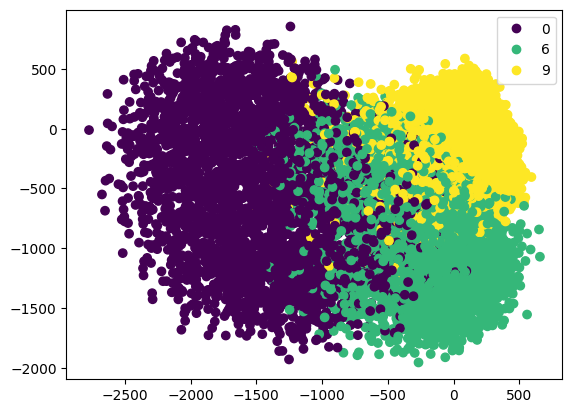

In [16]:
plot_clusters_2D(X_PCA_train, Y_train)

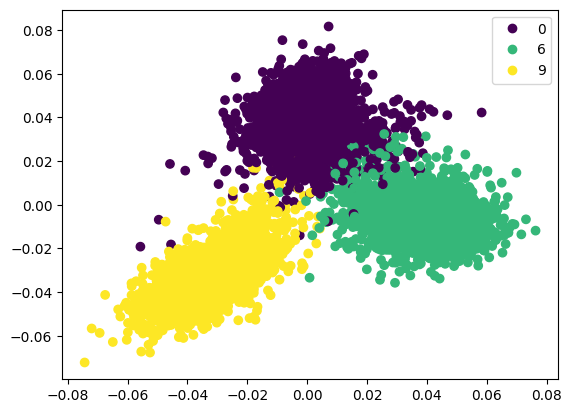

In [17]:
plot_clusters_2D(X_LDA_train, Y_train)

In [18]:
def avg_distance_centroids(X, Y):
    # get unique label values
    unique_idxs = np.unique(Y)
    
    # create the clusters divided by class
    distances = []
    centroids = []
    for i in unique_idxs:
        cluster = X[:, (Y==i)]
        d, N = cluster.shape
        centroid = np.mean(cluster, axis=1)
        print("Coordinates of centroid corresponding to index {}: [{:.2f}, {:.2f}]".format(
            i,
            centroid[0],
            centroid[1]
        ))

        distances.append([np.linalg.norm(cluster[:,j] - centroid) for j in range(N)])
        centroids.append(centroid)

    global_centroid = np.mean(X, axis=1)
    print("Coordinates of global centroid: [{:.2f}, {:.2f}]".format(
        global_centroid[0],
        global_centroid[1]
    ))

    centroid_avg_distance_to_global = np.mean([np.linalg.norm(c-global_centroid) for c in centroids])
    return np.mean(np.concatenate(distances)), centroid_avg_distance_to_global


In [19]:
distance_PCA, avg_centroid_distance = avg_distance_centroids(X_PCA_train, Y_train)
print("Average distance from point to corresponding centroid with PCA: {:.2f}".format(distance_PCA))
print("After normalization by average centroid distance: {:.2f}".format(distance_PCA / avg_centroid_distance))

Coordinates of centroid corresponding to index 0: [-1425.00, -555.92]
Coordinates of centroid corresponding to index 6: [-223.43, -896.67]
Coordinates of centroid corresponding to index 9: [66.12, -107.31]
Coordinates of global centroid: [-529.50, -517.98]
Average distance from point to corresponding centroid with PCA: 552.21
After normalization by average centroid distance: 0.79


In [20]:
distance_LDA, avg_centroid_distance = avg_distance_centroids(X_LDA_train, Y_train)
print("Average distance from point to corresponding centroid with PCA: {:.2f}".format(distance_LDA))
print("After normalization by average centroid distance: {:.2f}".format(distance_LDA / avg_centroid_distance))

Coordinates of centroid corresponding to index 0: [0.00, 0.04]
Coordinates of centroid corresponding to index 6: [0.04, -0.01]
Coordinates of centroid corresponding to index 9: [-0.03, -0.03]
Coordinates of global centroid: [0.00, -0.00]
Average distance from point to corresponding centroid with PCA: 0.01
After normalization by average centroid distance: 0.28


In [21]:
X_PCA_test = projection_matrix_PCA @ X_test
distance_PCA_test, avg_centroid_distance = avg_distance_centroids(X_PCA_test, Y_test)
print("Average distance from point to corresponding centroid with PCA: {:.2f}".format(distance_PCA_test))
print("After normalization by average centroid distance: {:.2f}".format(distance_PCA_test / avg_centroid_distance))

Coordinates of centroid corresponding to index 0: [-1432.15, -535.32]
Coordinates of centroid corresponding to index 6: [-214.45, -891.27]
Coordinates of centroid corresponding to index 9: [48.42, -108.57]
Coordinates of global centroid: [-510.45, -511.45]
Average distance from point to corresponding centroid with PCA: 541.58
After normalization by average centroid distance: 0.78


In [22]:
X_LDA_test = projection_matrix_LDA @ X_test
distance_LDA_test, avg_centroid_distance = avg_distance_centroids(X_LDA_test, Y_test)
print("Average distance from point to corresponding centroid with LDA: {:.2f}".format(distance_LDA_test))
print("After normalization by average centroid distance: {:.2f}".format(distance_LDA_test / avg_centroid_distance))

Coordinates of centroid corresponding to index 0: [0.00, 0.04]
Coordinates of centroid corresponding to index 6: [0.04, -0.01]
Coordinates of centroid corresponding to index 9: [-0.03, -0.03]
Coordinates of global centroid: [0.00, -0.00]
Average distance from point to corresponding centroid with LDA: 0.01
After normalization by average centroid distance: 0.32


### Explanation of previous results

PCA only projects the initial datapoint on their main components given by the eigenvectors of the reduced $U_k$ matrix.

LDA instead takes into consideration both their intra-cluster covariance and also their between-cluster covariance when computing Sb and Sw, so the datapoints are not only projected on their main components, but also "normalized".

This explains the enormous difference between the PCA average distance of ~500 and the small ~0.01 distance for LDA. When normalize the average distance point-centroid with the average distance centroid-global_centroid, PCA returns ~0.8 while LDA returns ~0.3, meaning that the two algorithms actually behave similarly. However, LDA still produces a lower number, meaning that, on average, the points are nearer to their centroid, fact that is very clear also through the plots.

In [23]:
def classify_sample(sample, centroids, classes):
    distances = [np.linalg.norm(sample-c) for c in centroids]
    return classes[np.argmin(distances)]

def get_accuracy(X_train, Y_train, X_test, Y_test):
    # get unique label values
    classes = np.unique(Y_train)
    
    centroids = []
    # create the clusters divided by class
    for i in classes:
        cluster = X_train[:, (Y_train==i)]
        centroids.append(np.mean(cluster, axis=1))

    correct_predictions = 0
    for sample, gt_class in zip(X_test.T, Y_test):
        predicted_class = classify_sample(sample, centroids, classes)
        if predicted_class == gt_class:
            correct_predictions += 1

    return correct_predictions / len(Y_test)    

In [24]:
print("PCA accuracy on test set: {:.2f}%".format(get_accuracy(X_PCA_train, Y_train, X_PCA_test, Y_test)*100))

PCA accuracy on test set: 83.90%


In [25]:
print("LDA accuracy on test set: {:.2f}%".format(get_accuracy(X_LDA_train, Y_train, X_LDA_test, Y_test)*100))

LDA accuracy on test set: 97.75%


Since LDA is actually trained on the dataset, the accuracy should always be higher than PCA when doing classification

In [26]:
def complete_experiment(X_train, Y_train, X_test, Y_test, digits, k):
    # We already create the dataset splits that contain ALL the digits, then we filter them
    # otherwise, every different try will have different splits and different results

    X_train, Y_train = get_data_from_index(X_train, Y_train, digits)
    X_test, Y_test = get_data_from_index(X_test, Y_test, digits)

    projection_matrix_PCA = PCA(X_train, k)
    projection_matrix_LDA = LDA(X_train, Y_train, k)

    X_PCA_train = projection_matrix_PCA @ X_train
    X_LDA_train = projection_matrix_LDA @ X_train

    X_PCA_test = projection_matrix_PCA @ X_test
    X_LDA_test = projection_matrix_LDA @ X_test

    acc_PCA = get_accuracy(X_PCA_train, Y_train, X_PCA_test, Y_test)
    acc_LDA = get_accuracy(X_LDA_train, Y_train, X_LDA_test, Y_test)

    return acc_PCA, acc_LDA

In [27]:
data = pd.read_csv(os.path.join(ROOT_PATH, "data", "data.csv"))
data = np.array(data)
X = data[:, 1:]
X = X.T
Y = data[:, 0]
N_train = round(X.shape[1]*train_split)
(X_train, Y_train), (X_test, Y_test) = data_splits(X, Y, N_train)

In [28]:
k_values = np.arange(2,13,1)
results = [complete_experiment(X_train, Y_train, X_test, Y_test, [0, 6, 9], k) for k in tqdm(k_values)]

100%|██████████| 11/11 [05:00<00:00, 27.33s/it]


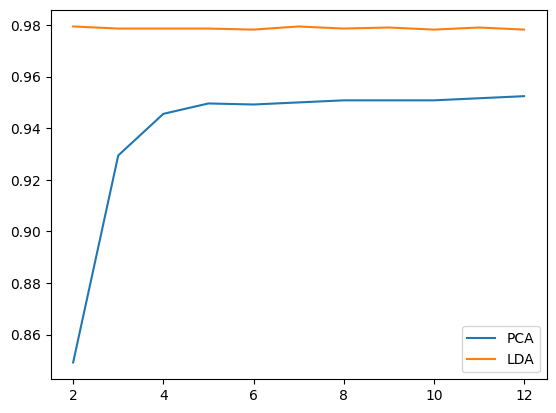

In [29]:
plt.plot(k_values, [r[0] for r in results], k_values,  [r[1] for r in results])
plt.legend(["PCA", "LDA"])
plt.show()

We can see that LDA is actually always better than PCA even growing with the dimensions, because it trains on the data and can exploit labels. We can also see that PCA improves with growing k, because in higher dimensions it is probably easier to find space to separate the clusters, or, seen in another way, it's easier to find directions that differenciate better between groups

In [30]:
digit_values = [
    [2, 5],
    [1, 7],
    [0, 6, 9],
    [8, 4, 7, 3],
    [0, 1, 2, 3, 4, 5, 6],
]

results = [complete_experiment(X_train, Y_train, X_test, Y_test, d, 2) for d in tqdm(digit_values)]

100%|██████████| 5/5 [03:27<00:00, 41.48s/it]


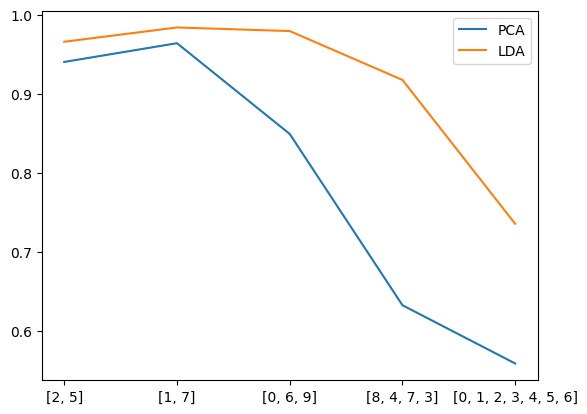

In [31]:
x_range = np.arange(0, len(digit_values))
plt.plot(x_range, [r[0] for r in results], x_range, [r[1] for r in results])
plt.xticks(x_range, digit_values)
plt.legend(["PCA", "LDA"])
plt.show()

Here instead we spot that, as we could have predicted, having more clusters usually leads to a more difficult classification and a lowering in accuracy

### Remark: i think that the algorithm for LDA written in that way is unstable, the results do not always make sense

# Second part

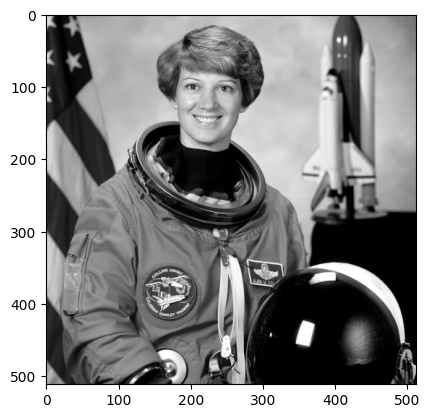

In [32]:
img = np.array(skimage.color.rgb2gray(skimage.data.astronaut()))
plt.imshow(img, cmap="gray")
plt.show()

In [33]:
total_img_shown = 12
rows = 2
columns = 6
more_imgs = 200

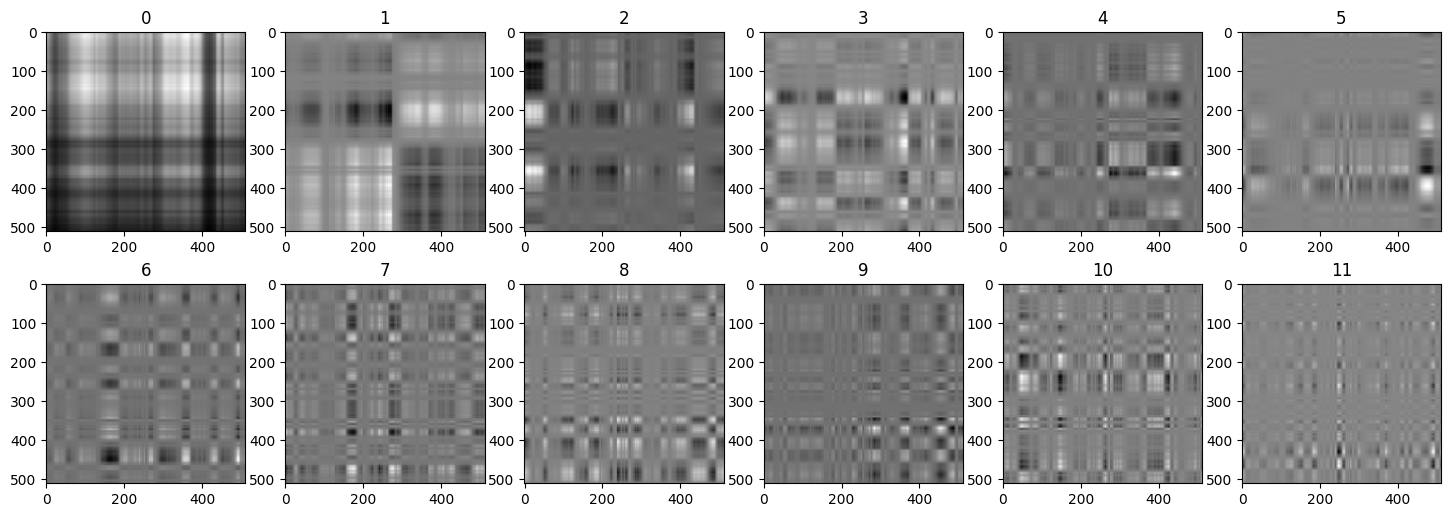

In [34]:
# Compute SVD of the image
U, s, VT = np.linalg.svd(img, full_matrices=False)

def get_k_dyad(U, s, VT, k):
    # get the dyad of order k from the full matrices
    u_k = U[:, k] # select row k from U
    v_k = VT[k, :] # select column k from VT
    A = s[k] * (np.reshape(u_k, (len(u_k), 1))  @ np.reshape(v_k, (1, len(v_k)))) # multiply everything together paying attention to the dimensions
    return A

# get the dyads for the first "total_img_shown" values
dyads = [get_k_dyad(U, s, VT, k) for k in np.arange(more_imgs)]

# plot a few of them
_, axs = plt.subplots(rows, columns, figsize=(18, 6))
axs = axs.flatten()
for i, (dyad, ax) in enumerate(zip(dyads[:total_img_shown], axs)):
    ax.imshow(dyad, cmap='gray')
    ax.set_title(i)
plt.show()

A matrix $A ∈ R^{m, n}$ is called a dyad if it can be written as $A = pq^T$

It seems that the first dyads have:
1. much higher contrast, probably caused by the higher singular value associated with them
2. less spikes in the data, smoother transitions --> this probably means that they are associated with higher order features and not with small details in the image (ex. first dyad could just define the "light" and "dark" zones in the image)

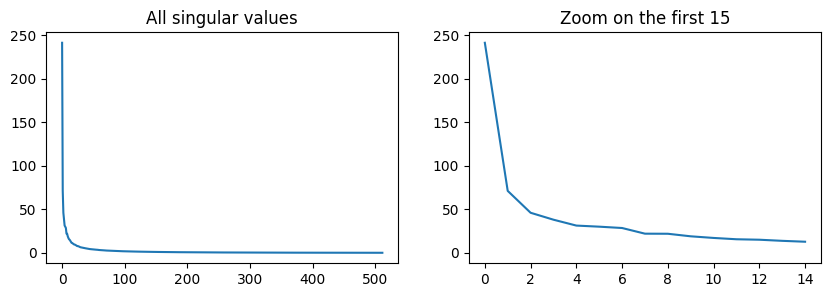

In [35]:
# Plot the distribution of singular values
_, axs = plt.subplots(1, 2, figsize=(10, 3))
axs = axs.flatten()
axs[0].plot(s)
axs[0].set_title("All singular values")
y_lims = axs[0].get_ylim()
# zoom on the first 15 values to better understand distribution
axs[1].plot(s[:15])
axs[1].set_ylim(y_lims)
axs[1].set_title("Zoom on the first 15")
plt.show()

We can see that the difference between the first and second singular value is bigger than the difference between the second and the smallest. From this we can understand that the main contrast difference in the image is given by the first few dyads, and the other ones only give small contributions

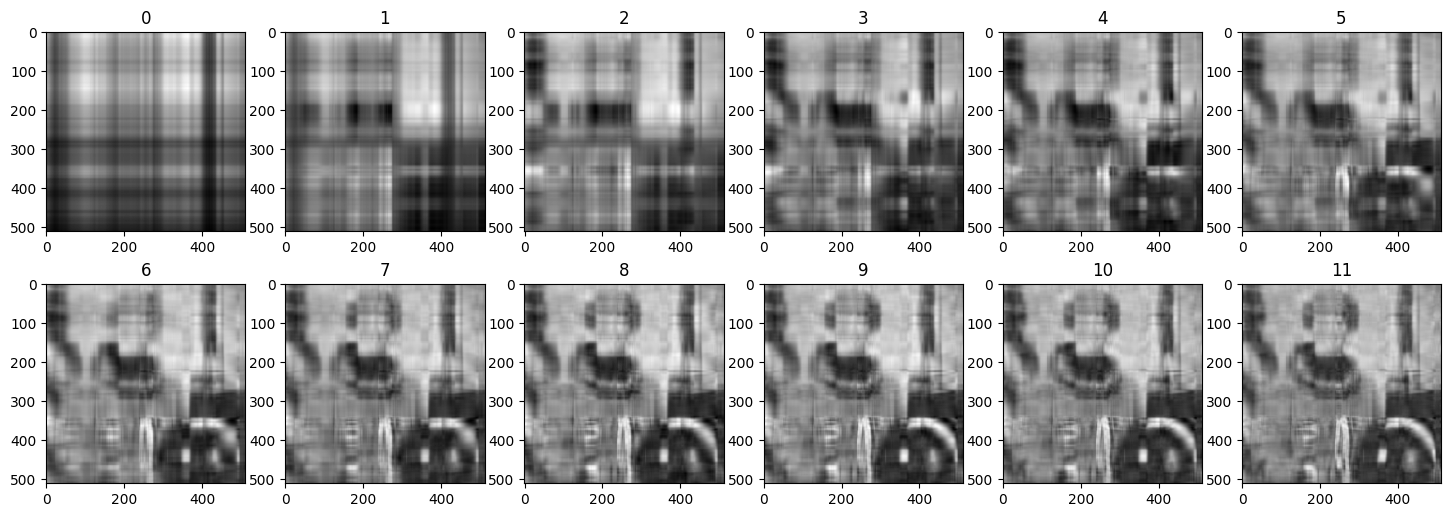

In [36]:
# simply sum all of the dyads before to get the k-rank approximation
k_rank_approximations = [dyads[0]]
for i in range(len(dyads)-1):
    k_rank_approximations.append(np.sum([k_rank_approximations[i], dyads[i+1]], axis=0))

# plot a few of them
_, axs = plt.subplots(rows, columns, figsize=(18, 6))
axs = axs.flatten()
for i, (k_approx, ax) in enumerate(zip(k_rank_approximations[:total_img_shown], axs)):
    ax.imshow(k_approx, cmap='gray')
    ax.set_title(i)
plt.show()

We can see that, as previously predicted, the first images define the general dark/light zones of the image, while the othe ones augment smaller details. We can also see that we can start recognizing the image from as early as the sixth or seventh approximation, truly a great reduction.

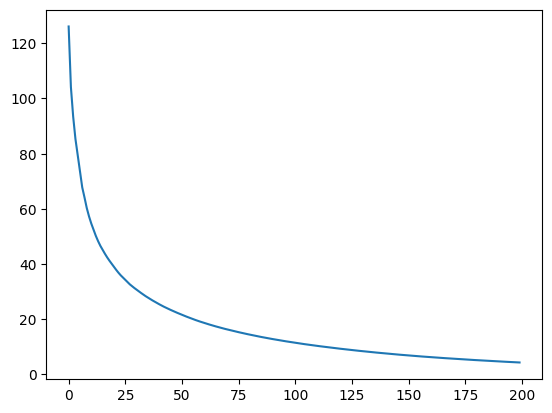

In [37]:
approximation_error = [np.linalg.norm(img-k_approx) for k_approx in k_rank_approximations]
plt.plot(approximation_error)
plt.show()

As was predictable, the error diminishes with every growing k. But the biggest part of the approximation error is removed after just a few steps

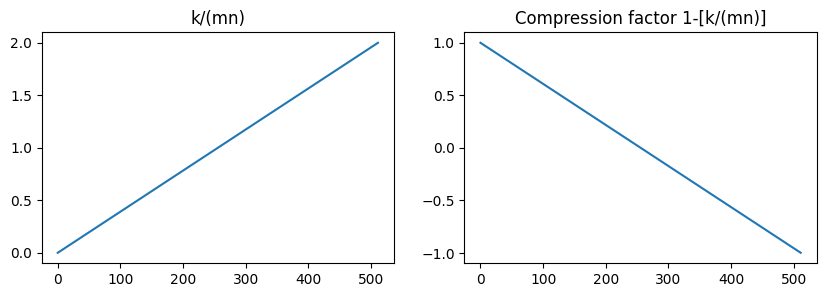

In [38]:
k_mn = [(k*(1+U.shape[0]+VT.shape[1])) / (U.shape[0]*VT.shape[1]) for k in range(len(s))]
compression_factor = [1-c for c in k_mn]

_, axs = plt.subplots(1, 2, figsize=(10, 3))
axs = axs.flatten()
axs[0].plot(k_mn)
axs[0].set_title("k/(mn)")
axs[1].plot(compression_factor)
axs[1].set_title("Compression factor 1-[k/(mn)]")
plt.show()

We can see that the compression factor scales linearly from 1 to -1 throughout k, with k from 0 to $rk(X)$ --> this means that it is a compression only up until $k \sim rk(X)/2$, then it uses more information to store the same image. In fact $k*(1+m+n)$ when $m=n=k$ is $2k^2 + k$, that divided by $k^2$ is ~2